In [1]:
# !pip install -q git+https://github.com/matjesg/deepflash2.git

In [2]:
# !pip install zarr

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [5]:
# imports
import zarr, cv2, json
import numpy as np, pandas as pd, segmentation_models_pytorch as smp
from deepflash2.all import *
from deepflash2.transforms import random_center
import albumentations as alb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T

import torch.utils.data as D

from tqdm.notebook import tqdm

In [6]:
from config.global_vars import *
from datasets.hubdataset import HubDataset

In [7]:
# Model
def create_model():
    model = smp.MAnet(encoder_name=ENCODER_NAME, 
                     encoder_weights=ENCODER_WEIGHTS,
                     activation=None,
                     in_channels=CHANNELS, 
                     classes=2)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model.cuda()
    model.train()
    return model

model = create_model()

### Configuration

In [8]:
dice_loss = smp.losses.DiceLoss(mode='multilabel', from_logits=True)
smp.losses.DiceLoss.__name__ = 'Dice Loss'
dice_loss.__name__ = 'Dice Loss'

jaccard_loss = smp.losses.JaccardLoss(mode='multilabel', from_logits=True)
smp.losses.JaccardLoss.__name__ = 'Jaccard Loss'
jaccard_loss.__name__ = 'Jaccard Loss'

cross_entropy_loss_base = smp.losses.SoftCrossEntropyLoss(smooth_factor=1e-5)

def cross_entropy_loss(y_pred, y):
    y = y.to(torch.int64)
    return cross_entropy_loss_base(y_pred, y)

LOSS_FACTOR = 0.2
def dice_ce_loss(y_pred, y):
    y = y.long()
    y_target = y.sum(1)
    return dice_loss(y_pred, y) * LOSS_FACTOR + cross_entropy_loss(y_pred, y_target) * (1 - LOSS_FACTOR)

In [9]:
class CONFIG():
    
    # data paths
    data_path = Path('/home/jupyter/data_2/')
    data_path_zarr = Path('/home/jupyter/train_scale2')
    mask_preproc_dir = '/home/jupyter/masks_scale2'
    
    # deepflash2 dataset
    # scale = 1.5 # data is already downscaled to 2, so absulute downscale is 3
    scale = 1 # data is already downscaled to 2, so absulute downscale is 3
    tile_shape = (TILE_SHAPE, TILE_SHAPE)
    padding = (0,0) # Border overlap for prediction
    n_jobs = NUM_WORKERS
    sample_mult = 100 # Sample 100 tiles from each image, per epoch
    val_length = 500 # Randomly sample 500 validation tiles
    stats = np.array([0.61561477, 0.5179343 , 0.64067212]), np.array([0.2915353 , 0.31549066, 0.28647661])
    
    # deepflash2 augmentation options
    zoom_sigma = 0.1
    flip = True
    max_rotation = 360
    deformation_grid_size = (150,150)
    deformation_magnitude = (10,10)

    # pytorch model (segmentation_models_pytorch)
    encoder_name = ENCODER_NAME
    encoder_weights = ENCODER_WEIGHTS
    in_channels = 3
    classes = 2
    
    # fastai Learner 
    mixed_precision_training = True
    batch_size = 5
    weight_decay = 0.01
    loss_func = dice_loss
#     metrics = [Iou(), Dice_f1()]
    max_learning_rate = 5e-4
    epochs = 12
    optimizer = torch.optim.AdamW(model.parameters(), lr=max_learning_rate, weight_decay=weight_decay)
    model = model
    arch = 'unet'
    patience = 8
    
cfg = CONFIG()

In [10]:
# Albumentations augmentations
# Inspired by https://www.kaggle.com/iafoss/hubmap-pytorch-fast-ai-starter
# deepflash2 augmentations are only affine transformations
tfms = alb.Compose([alb.OneOf([
    alb.HueSaturationValue(10,15,10),
    alb.CLAHE(clip_limit=2),
    alb.RandomBrightnessContrast(),
    alb.OneOf([
        alb.MotionBlur(p=0.2),
        alb.MedianBlur(blur_limit=3, p=0.1),
        alb.Blur(blur_limit=3, p=0.1),
    ]),
    alb.ISONoise (color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False)
], p=0.3)])

In [11]:
df_train = pd.read_csv(cfg.data_path/'train.csv')
df_info = pd.read_csv(cfg.data_path/'HuBMAP-20-dataset_information.csv')

files = [x for x in cfg.data_path_zarr.iterdir() if x.is_dir() if not x.name.startswith('.')]
label_fn = lambda o: o

In [12]:
!ls {cfg.mask_preproc_dir}

labels	pdfs


### Datasets

In [13]:
# Datasets
ds_kwargs = {
    'tile_shape':cfg.tile_shape,
    'padding':cfg.padding,
    'scale': cfg.scale,
    'n_jobs': cfg.n_jobs, 
    'preproc_dir': cfg.mask_preproc_dir, 
    'val_length':cfg.val_length, 
    'sample_mult':cfg.sample_mult,
    'loss_weights':False,
    'zoom_sigma': cfg.zoom_sigma,
    'flip' : cfg.flip,
    'max_rotation': cfg.max_rotation,
    'deformation_grid_size' : cfg.deformation_grid_size,
    'deformation_magnitude' : cfg.deformation_magnitude,
    'albumentations_tfms': tfms
}

In [14]:
# Patching

def read_img(self:BaseDataset, file, *args, **kwargs):
    return zarr.open(str(file), mode='r')

BaseDataset.read_img = read_img

def _name_fn(self:BaseDataset, g):
    "Name of preprocessed and compressed data."
    return f'{g}'

BaseDataset._name_fn = _name_fn

def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr files)
    sl = []
    for i in range(len(coords)):
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        dmax = data.shape[i]
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        sl.append(slice(cmin, cmax))    
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        for c in range(data.shape[-1]):
            # Adding divide
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile

DeformationField.apply = apply

from fastai.torch_core import TensorImage
from fastai.torch_core import TensorMask

def convert_to_multiclass(mask):
    true_1_hot = torch.eye(2)[mask].squeeze()
    true_1_hot = true_1_hot.permute(2, 0, 1)
    return true_1_hot

normalize_transform = T.Normalize(cfg.stats[0], cfg.stats[1])

RandomTileDataset.convert_to_multiclass = convert_to_multiclass

def __getitem_rs__(self:RandomTileDataset, idx):
    idx = idx % len(self.files)
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_path = self.files[idx]
    img = self.read_img(img_path, divide=self.divide)
    n_channels = img.shape[-1]

    lbl, pdf  = self.labels[img_path.name], self.pdfs[self._name_fn(img_path.name)]
    center = random_center(pdf[:], lbl.shape, TILE_SHAPE)
    X = self.gammaFcn(self.deformationField.apply(img, center).flatten()).reshape((*self.tile_shape, n_channels))
    Y = self.deformationField.apply(lbl, center, self.padding, 0)
    X1 = X.copy()

    if self.albumentations_tfms:
        augmented = self.albumentations_tfms(image=(X*255).astype('uint8'),mask=Y.astype('uint8'))
#         print(augmented['replay'])
        X = (augmented['image']/255)
        Y = augmented['mask']

    X = X.transpose(2, 0, 1).astype('float32')
    Y = Y.astype('int64')
    
    Y = torch.from_numpy(Y)
#     Y = convert_to_multiclass(Y)
    X = torch.from_numpy(X)
    X = normalize_transform(X)

    if self.loss_weights:
        _, W = cv2.connectedComponents((Y > 0).astype('uint8'), connectivity=4)
        return X, Y, torch.Tensor(W)
    else:
        return X, Y
    

RandomTileDataset.__getitem__ = __getitem_rs__

def __getitem_ts__(self:TileDataset, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.valid_indices: idx = self.valid_indices[idx]
        img_path = self.files[self.image_indices[idx]]
        img = self.data[img_path.name]
        centerPos = self.centers[idx]
        X = self.tiler.apply(img, centerPos)
        X = X.transpose(2, 0, 1).astype('float32')
        if self.label_fn is not None:
            lbl = self.labels[img_path.name]
            Y = self.tiler.apply(lbl, centerPos, self.padding, order=0).astype('int64')
            Y = torch.from_numpy(Y)
#             Y = convert_to_multiclass(Y)
            X = torch.from_numpy(X)
            X = normalize_transform(X)
            if self.loss_weights:
                _, W = cv2.connectedComponents((Y > 0).astype('uint8'), connectivity=4)
                return X, Y, torch.Tensor(W)
            else:
                return X, Y
        else:
            return torch.from_numpy(X)
        
TileDataset.__getitem__ = __getitem_ts__

In [15]:
root_dir = cfg.data_path
slices_path = SLICES_PATH
window = WINDOW
overlap = OVERLAP
threshold = THRESHOLD

In [16]:
train_ds = RandomTileDataset(files, label_fn=label_fn, **ds_kwargs)

Using preprocessed masks from /home/jupyter/masks_scale2


In [17]:
valid_ds = TileDataset(files, label_fn=label_fn, **ds_kwargs, is_zarr=True)

Using preprocessed masks from /home/jupyter/masks_scale2


In [18]:
sample_image, sample_mask = train_ds[0]

In [19]:
sample_image.shape, sample_mask.shape

(torch.Size([3, 768, 768]), torch.Size([768, 768]))

In [20]:
import matplotlib.pyplot as plt

def plot_img_mask(score, raw_image, index):
#     score = np.argmax(score, 0)
    fig, ax = plt.subplots(ncols=2, figsize=(15,15))
    resize_w = 250
    resize = 250
    ax[0].imshow(score)
    ax[0].set_title(f'Mask {index}')
    ax[0].set_axis_off()
    ax[1].imshow(np.moveaxis(raw_image, 0, -1))
    ax[1].set_title(f'Image {index}')
    ax[1].set_axis_off()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

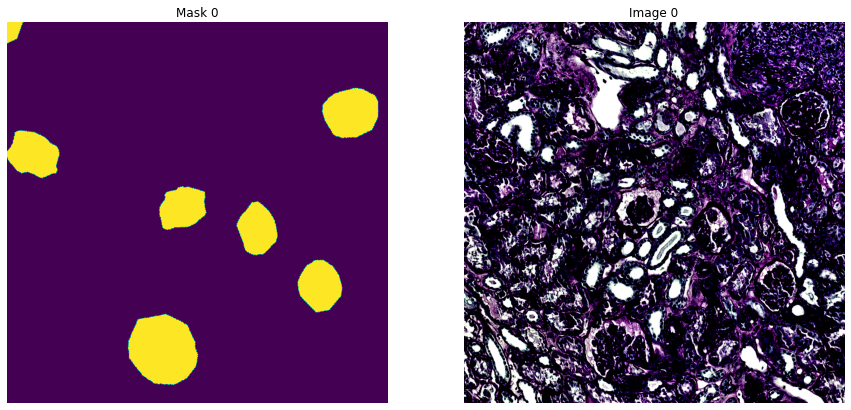

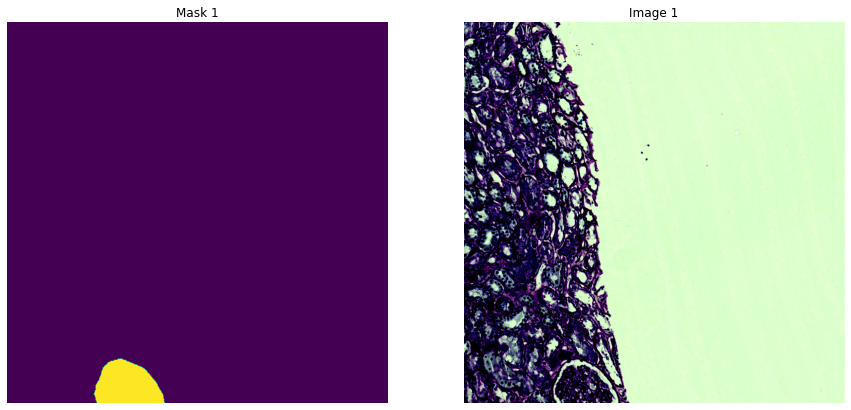

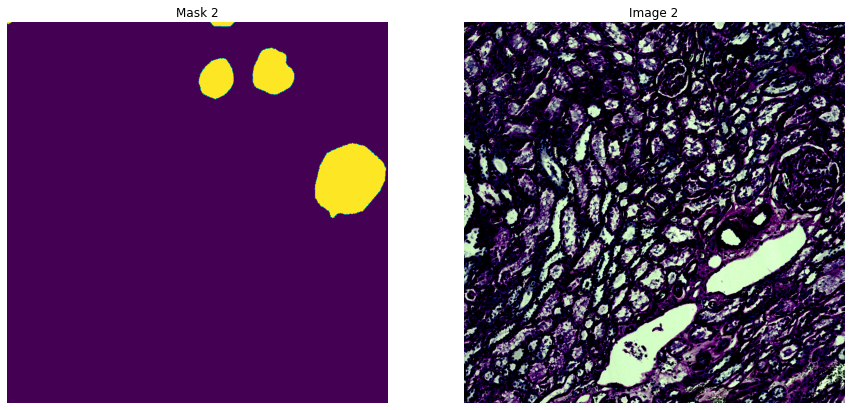

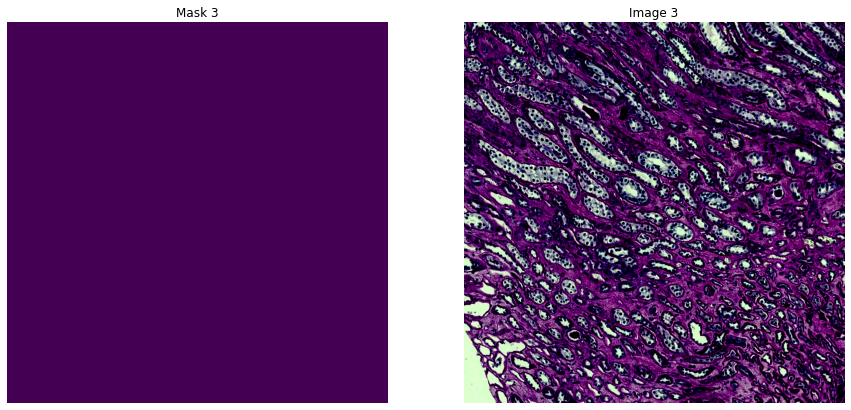

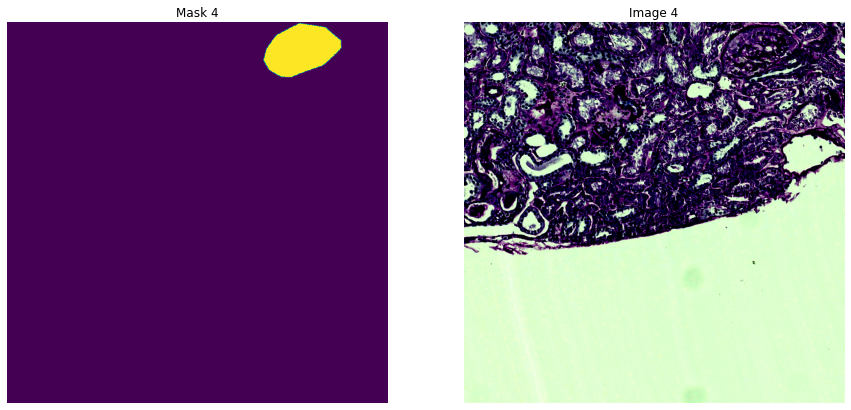

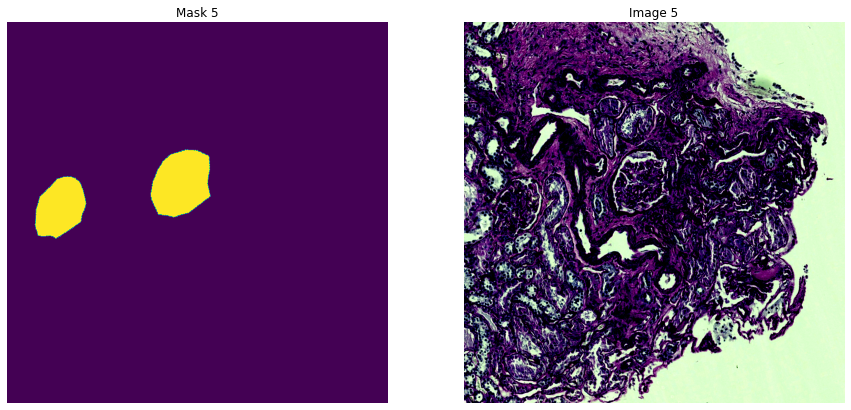

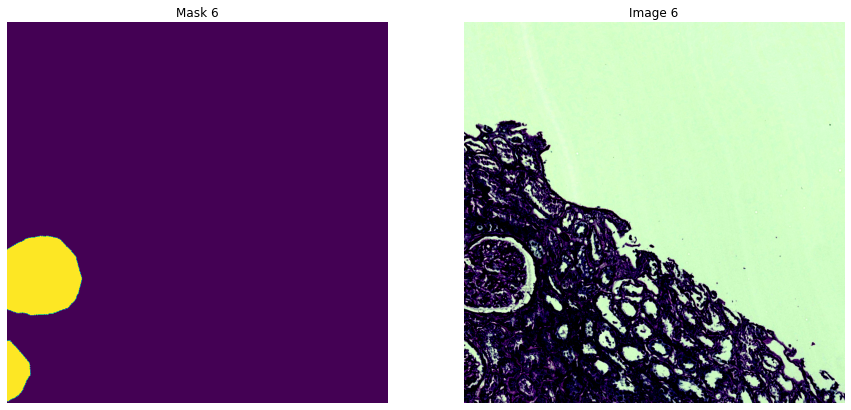

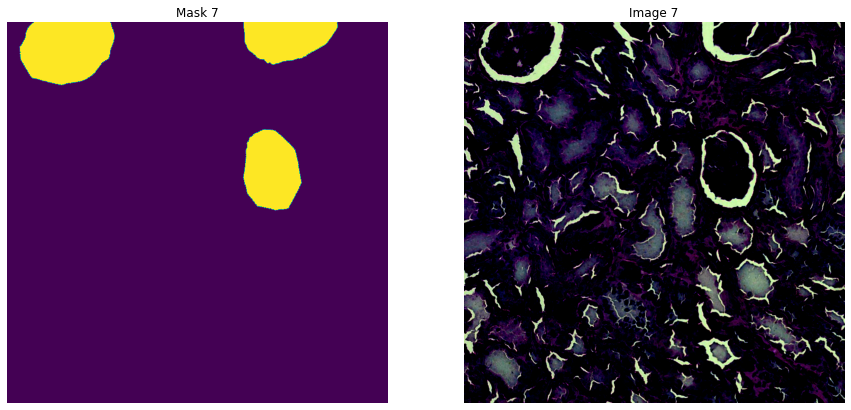

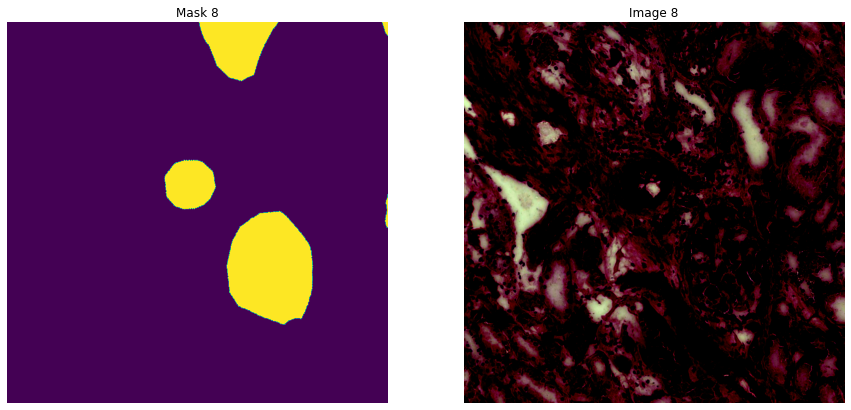

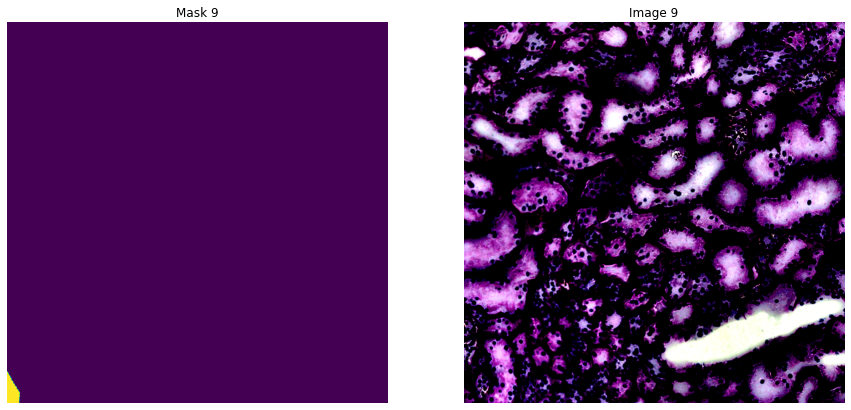

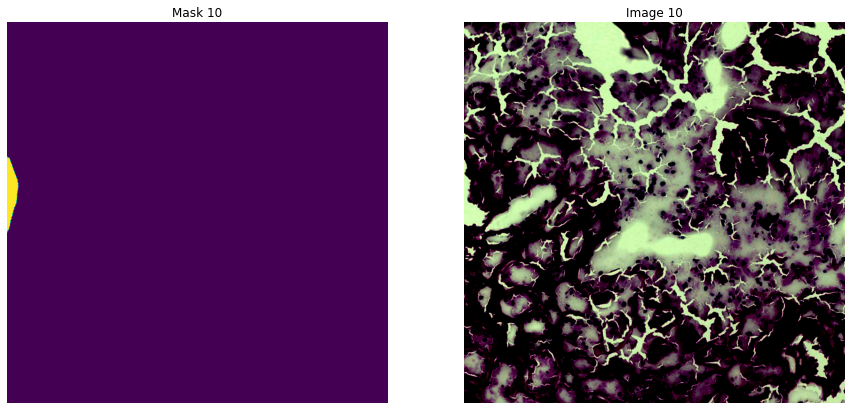

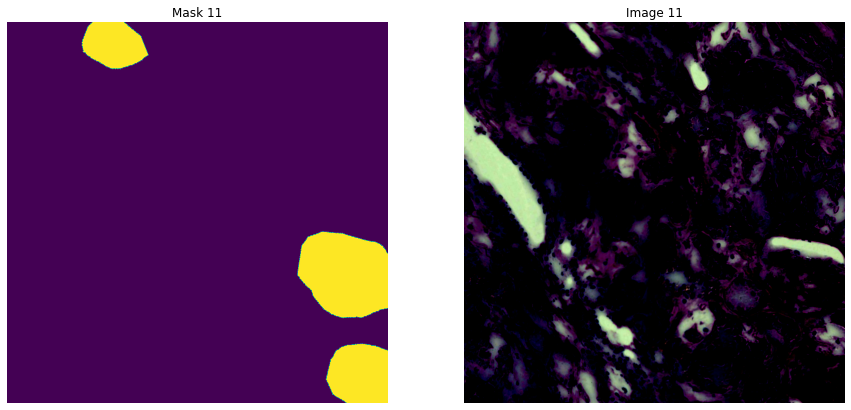

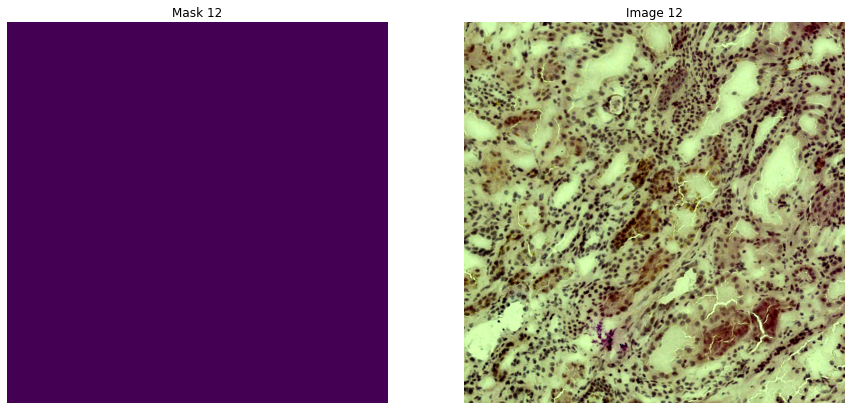

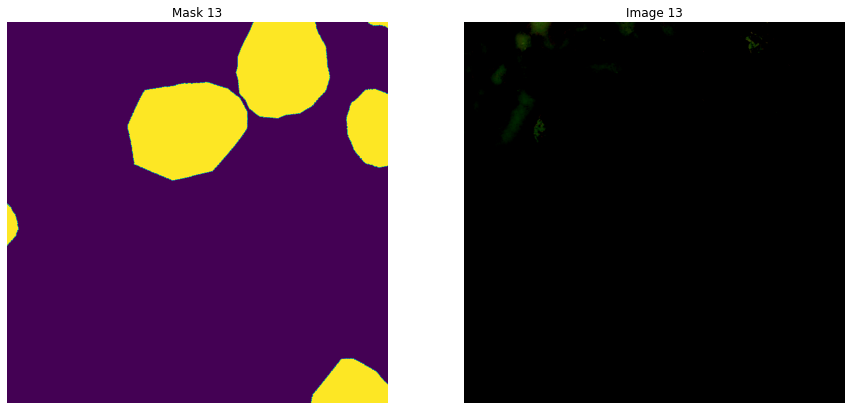

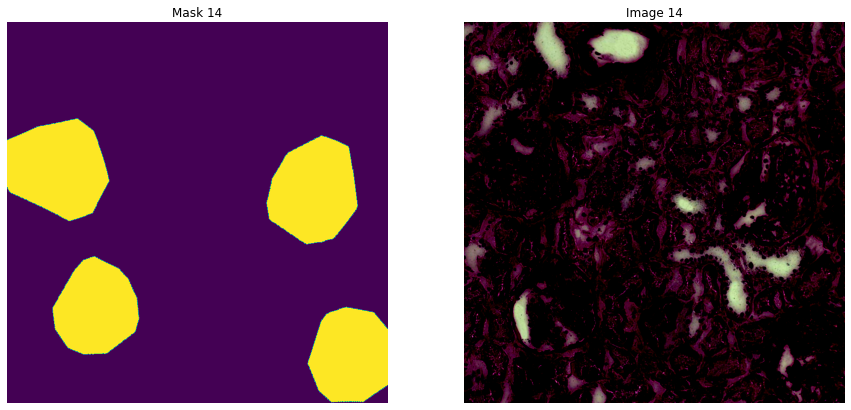

In [21]:
for i in range(15):
    image, mask = train_ds[i]
#     mask = torch.argmax(mask, 0)
    plot_img_mask(mask.numpy(), image.numpy(), i)

In [22]:
image.shape, mask.shape, mask.dtype

(torch.Size([3, 768, 768]), torch.Size([768, 768]), torch.int64)

### DataLoaders

In [23]:
train_dl = D.DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.n_jobs)
valid_dl = D.DataLoader(valid_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.n_jobs)

# train_dl = D.DataLoader(train_ds_2, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.n_jobs)
# valid_dl = D.DataLoader(train_ds_2, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.n_jobs)

In [24]:
image_batch, mask_batch = next(iter(train_dl))
image_batch.shape, mask_batch.shape

(torch.Size([5, 3, 768, 768]), torch.Size([5, 768, 768]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


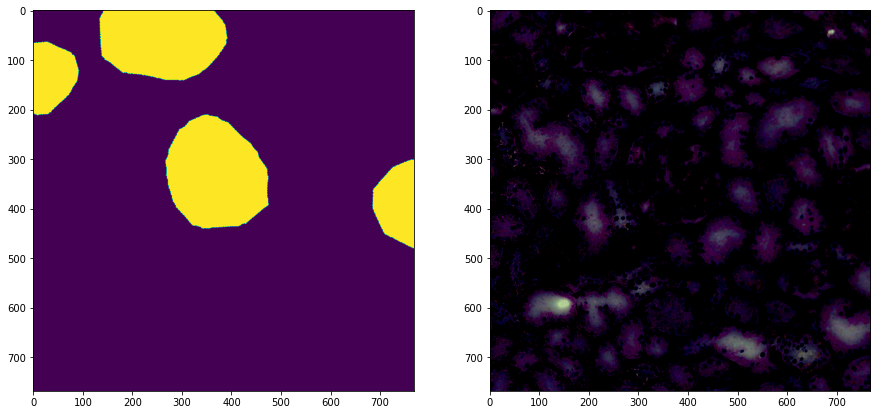

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(15,15))
# mask_batch[0] = torch.argmax(mask_batch[0], 0)
ax[0].imshow(mask_batch[0])
sample_img = image_batch[0]
ax[1].imshow(np.moveaxis(sample_img.numpy(), 0, -1))

### Losses and Metrics

In [26]:
def calc_intersection_cardinality(y_pred, y, dims=(-2, -1)):
    x = y_pred
    x = torch.argmax(x, 1)
#     y = torch.argmax(y, 1)
    intersection = (x * y).to(torch.int8).sum(dims)
    cardinality = (x + y).to(torch.int8).sum(dims)
    return intersection, cardinality

def dice_metric(y_pred, y, epsilon = 1e-7, dims=(-2, -1)):
    intersection, cardinality = calc_intersection_cardinality(y_pred, y)
    dc = (2 * intersection + epsilon) / (cardinality + epsilon)
    return dc.mean()

def iou_metric(y_pred, y, epsilon = 1e-7, dims=(-2, -1)):
    intersection, cardinality = calc_intersection_cardinality(y_pred, y)
    dc = (intersection + epsilon) / (cardinality - intersection + epsilon)
    return dc.mean()

dice_metric_2 = smp.utils.metrics.Fscore()

### Training

In [27]:
all_metrics = [dice_metric, iou_metric]

In [28]:
criterion = cross_entropy_loss

In [29]:
model_file = 'models/best_model_manet_pdf.pth'

In [30]:
best_metric = 0
scheduler = torch.optim.lr_scheduler.OneCycleLR(cfg.optimizer, max_lr=cfg.max_learning_rate,
                                                steps_per_epoch=len(train_dl), epochs=cfg.epochs)

for epoch in tqdm(range(cfg.epochs)):  # loop over the dataset multiple times

    running_loss = 0.0
    tbar = tqdm(train_dl, position=0, leave=True)
    cfg.model.train()
    
    loss_sum = 0
    iou_sum = 0
    
    scaler = torch.cuda.amp.GradScaler() # mixed precision support
    
    for i, data in enumerate(tbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.squeeze().float().to(DEVICE)
        if inputs.size(0) == labels.size(0):
            
            with torch.cuda.amp.autocast():
                # forward + backward + optimize
                outputs = cfg.model(inputs)
                loss = criterion(outputs, labels)
                iou = iou_metric(outputs, labels)
                
            scaler.scale(loss).backward()
            
            # Unscales the gradients of optimizer's assigned params in-place
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            scaler.step(cfg.optimizer)
            scale = scaler.get_scale()
            scaler.update()
            
            skip_lr_sched = (scale != scaler.get_scale())
            if not skip_lr_sched:
                scheduler.step()
                
            # zero the parameter gradients
            cfg.optimizer.zero_grad()
            
            loss_sum += loss
            iou_sum += iou

            # print statistics
            running_loss += loss.item()
        tbar.set_description(f'Train loss - {loss_sum.item() / (i + 1):.5f} iou - {iou_sum.item() / (i + 1):.5f}')

    print(f'Train Epoch {epoch}: Training loss {running_loss / len(train_dl):.5F}')
        
    tbar = tqdm(valid_dl, position=0, leave=True)
    cfg.model.eval()
    
    running_loss = 0.0
    iou_sum = 0
    metric_list = [[] for _ in all_metrics]
    with torch.no_grad():
        for i, data in enumerate(tbar):

            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
            
            outputs = cfg.model(inputs)
            
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            for ml, m in zip(metric_list, all_metrics):
                m_res = m(outputs, labels)
                ml.append(m_res.item())
                iou = m_res.item() # iou is the last item
                
            iou_sum += iou
                
            tbar.set_description(f'Valid loss - {running_loss / (i + 1):.5f} iou - {iou_sum / (i + 1):.5f}')

    dice_metric_mean = np.array(metric_list[0]).mean()
    iou_metric_mean = np.array(metric_list[1]).mean()
    
    if dice_metric_mean > best_metric:
        best_metric = dice_metric_mean
        print('Saving Model')
        torch.save(cfg.model.state_dict(), f'models/hubmap_best_model_{epoch}_manet_pdf.pth')
        
    print(f'Valid Epoch {epoch}: Validation loss {running_loss / len(valid_dl):.5F}; dice_metric: {dice_metric_mean:.5F}; iou: {iou_metric_mean:.5F}')
        
print('Finished Training')

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 0: Training loss 0.66946


  0%|          | 0/100 [00:00<?, ?it/s]

Saving Model
Valid Epoch 0: Validation loss 0.22637; dice_metric: 0.01605; iou: 0.01210


  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 1: Training loss 0.12855


  0%|          | 0/100 [00:00<?, ?it/s]

Saving Model
Valid Epoch 1: Validation loss 0.03381; dice_metric: 0.78410; iou: 0.75346


  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 2: Training loss 0.02901


  0%|          | 0/100 [00:00<?, ?it/s]

Saving Model
Valid Epoch 2: Validation loss 0.01298; dice_metric: 0.93355; iou: 0.91212


  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 3: Training loss 0.01861


  0%|          | 0/100 [00:00<?, ?it/s]

Saving Model
Valid Epoch 3: Validation loss 0.00793; dice_metric: 0.93944; iou: 0.92354


  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 4: Training loss 0.01563


  0%|          | 0/100 [00:00<?, ?it/s]

Saving Model
Valid Epoch 4: Validation loss 0.00725; dice_metric: 0.94828; iou: 0.93334


  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 5: Training loss 0.01341


  0%|          | 0/100 [00:00<?, ?it/s]

Valid Epoch 5: Validation loss 0.00728; dice_metric: 0.93960; iou: 0.92331


  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 6: Training loss 0.01252


  0%|          | 0/100 [00:00<?, ?it/s]

Saving Model
Valid Epoch 6: Validation loss 0.00810; dice_metric: 0.95772; iou: 0.94224


  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 7: Training loss 0.01151


  0%|          | 0/100 [00:00<?, ?it/s]

Saving Model
Valid Epoch 7: Validation loss 0.00706; dice_metric: 0.96233; iou: 0.94766


  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 8: Training loss 0.00992


  0%|          | 0/100 [00:00<?, ?it/s]

Valid Epoch 8: Validation loss 0.00745; dice_metric: 0.95111; iou: 0.93641


  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 9: Training loss 0.01189


  0%|          | 0/100 [00:00<?, ?it/s]

Valid Epoch 9: Validation loss 0.00737; dice_metric: 0.95465; iou: 0.94018


  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 10: Training loss 0.01037


  0%|          | 0/100 [00:00<?, ?it/s]

Valid Epoch 10: Validation loss 0.00739; dice_metric: 0.95242; iou: 0.93807


  0%|          | 0/300 [00:00<?, ?it/s]

Train Epoch 11: Training loss 0.00992


  0%|          | 0/100 [00:00<?, ?it/s]

Valid Epoch 11: Validation loss 0.00723; dice_metric: 0.95481; iou: 0.94056
Finished Training


In [31]:
!mv {model_file} models/hubmap_{model_file}

mv: cannot move 'models/best_model_manet_pdf.pth' to 'models/hubmap_models/best_model_manet_pdf.pth': No such file or directory
